In [ ]:
# Instalar a biblioteca (Colab)
!pip install scikit-fuzzy
# Bibliotecas
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.5 MB/s eta 0:00:00


In [ ]:
#Variáveis Antecedente
temperatura = ctrl.Antecedent(np.arange(-50, 91, 1), 'temperatura') #temperatura_de_ambiente em °C
fat_p = ctrl.Antecedent(np.arange(0.0,1.01,0.01), 'fator_potencia') # fator_de_potencia float
resist_iso = ctrl.Antecedent(np.arange(1000,12001,1), 'resistencia_isolamento') # resistencia_de_isolamento em Ω omns
carga_apl_motor = ctrl.Antecedent(np.arange(0,101,1), 'carga_aplicada') # carga_aplicada_motor em %
desbal_carga = ctrl.Antecedent(np.arange(0,11,1), 'desbalanceamento_carga') # desbalanceamento_de_carga em %

# Consequente
risco_falha = ctrl.Consequent(np.arange(0, 101, 1), 'risco_falha')

In [ ]:
# Funções de pertinência
temperatura['baixa'] = fuzz.trapmf(temperatura.universe, [-50, -50, -20, -20])
temperatura['normal'] = fuzz.trimf(temperatura.universe, [-20, 10, 40])
temperatura['alta'] = fuzz.trapmf(temperatura.universe, [40, 40, 90, 90])

fat_p['ruim'] = fuzz.trapmf(fat_p.universe, [0.0, 0.0, 0.80, 0.87])
fat_p['regular'] = fuzz.trimf(fat_p.universe, [0.87, 0.91, 0.95])
fat_p['bom'] = fuzz.trapmf(fat_p.universe, [0.95, 0.98, 1.0, 1.0])

resist_iso['baixa'] = fuzz.trapmf(resist_iso.universe, [1000, 1000, 2500, 2501])
resist_iso['media'] = fuzz.trimf(resist_iso.universe, [2500, 3750, 5000])
resist_iso['alta'] = fuzz.trapmf(resist_iso.universe, [5000, 5000, 12000, 12000])

carga_apl_motor['leve'] = fuzz.trapmf(carga_apl_motor.universe, [0, 0, 20, 40])
carga_apl_motor['media'] = fuzz.trimf(carga_apl_motor.universe, [30, 50, 70])
carga_apl_motor['pesada'] = fuzz.trapmf(carga_apl_motor.universe, [60, 80, 100, 100])

desbal_carga['baixo'] = fuzz.trapmf(desbal_carga.universe, [0, 0, 3, 5])
desbal_carga['medio'] = fuzz.trimf(desbal_carga.universe, [3, 5, 7])
desbal_carga['alto']  = fuzz.trapmf(desbal_carga.universe, [5, 7, 10, 10])


risco_falha['baixo'] = fuzz.trapmf(risco_falha.universe, [0,   0,  30,  50])
risco_falha['medio'] = fuzz.trimf(risco_falha.universe, [40,  60,  80])
risco_falha['alto'] = fuzz.trapmf(risco_falha.universe, [70,  90, 100, 100])

In [ ]:
#Regras

rule1 = ctrl.Rule(temperatura['alta'] | resist_iso['baixa'], risco_falha['alto'])
rule2 = ctrl.Rule(carga_apl_motor['pesada'] & desbal_carga['alto'], risco_falha['alto'])
rule3 = ctrl.Rule(fat_p['ruim'], risco_falha['medio'])
rule4 = ctrl.Rule(temperatura['normal'] & fat_p['bom'] & resist_iso['alta'], risco_falha['baixo'])
rule5 = ctrl.Rule(carga_apl_motor['media'] & desbal_carga['medio'], risco_falha['medio'])

# 2) Monta o sistema de controle
sistema = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
simulador = ctrl.ControlSystemSimulation(sistema)

In [ ]:
def regras_ativas_motor():
    try:
        # 1) Leitura das entradas
        temp = float(input("Temperatura (-50 a 90 ºC): "))
        fp = float(input("Fator de potência (0.0 a 1.0): "))
        ri = float(input("Resistência de isolamento (1000 a 12000 Ω): "))
        carga = float(input("Carga aplicada (0 a 100 %): "))
        desbal = float(input("Desbalanceamento de carga (0 a 10 %): "))

        # 2) Validação
        if not (-50 <= temp <= 90 and
                0.0 <= fp <= 1.0 and
                1000 <= ri <= 12000 and
                0 <= carga <= 100 and
                0 <= desbal <= 10):
            print("❌ Um ou mais valores estão fora dos limites permitidos.")
            return

        # 3) Exibe entradas
        print("\n🔍 Entradas informadas:")
        print(f"  • Temperatura: {temp:.1f} ºC")
        print(f"  • Fator de Potência: {fp:.2f}")
        print(f"  • Resistência de Isolamento: {ri:.0f} Ω")
        print(f"  • Carga Aplicada: {carga:.0f} %")
        print(f"  • Desbalanceamento de Carga: {desbal:.0f} %")

        # 4) Graus de pertinência
        def mostra_pert(ant, valor, nome):
            print(f"\n→ {nome}:")
            for termo in ant.terms:
                grau = fuzz.interp_membership(ant.universe,ant[termo].mf,valor)
                if grau > 0:
                    print(f"   • {termo}: {grau:.2%}")

        mostra_pert(temperatura, temp, "Temperatura")
        mostra_pert(fat_p, fp, "Fator de Potência")
        mostra_pert(resist_iso, ri, "Resistência Isolamento")
        mostra_pert(carga_apl_motor, carga, "Carga Aplicada")
        mostra_pert(desbal_carga, desbal, "Desbalanceamento Carga")

        # 5) Alimenta o simulador
        simulador.input['temperatura'] = temp
        simulador.input['fator_potencia'] = fp
        simulador.input['resistencia_isolamento'] = ri
        simulador.input['carga_aplicada'] = carga
        simulador.input['desbalanceamento_carga']= desbal

        # 6) Computa o risco de falha
        simulador.compute()
        risco = simulador.output['risco_falha']

        # 7) Imprime e plota o resultado
        print(f"\n✅ Resultado: Risco de Falha = {risco:.2f}%")
        print("\n📊 Exibindo curva do consequente (risco_falha)...")
        risco_falha.view(sim=simulador)
        plt.show()

    except Exception as e:
        print(f"❗ Erro durante a avaliação: {e}")

Temperatura (-50 a 90 ºC): -30
Fator de potência (0.0 a 1.0): 1.0
Resistência de isolamento (1000 a 12000 Ω): 10000
Carga aplicada (0 a 100 %): 50
Desbalanceamento de carga (0 a 10 %): 5

🔍 Entradas informadas:
  • Temperatura: -30.0 ºC
  • Fator de Potência: 1.00
  • Resistência de Isolamento: 10000 Ω
  • Carga Aplicada: 50 %
  • Desbalanceamento de Carga: 5 %

→ Temperatura:
   • baixa: 100.00%

→ Fator de Potência:
   • bom: 100.00%

→ Resistência Isolamento:
   • alta: 100.00%

→ Carga Aplicada:
   • media: 100.00%

→ Desbalanceamento Carga:
   • medio: 100.00%

✅ Resultado: Risco de Falha = 60.00%

📊 Exibindo curva do consequente (risco_falha)...


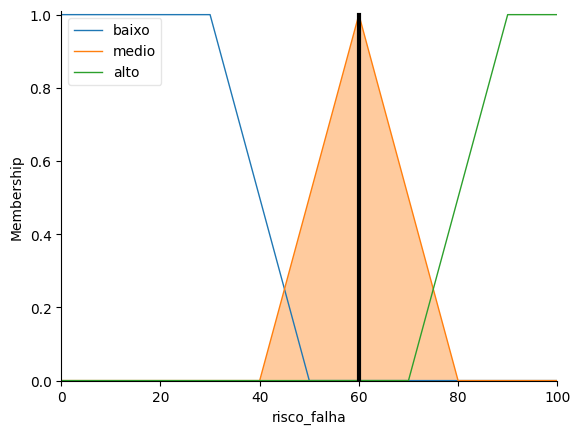

In [ ]:
regras_ativas_motor()

````markdown
# Documentação do Sistema de Controle Fuzzy para Risco de Falha de Motor

Este documento descreve passo a passo o código Python que implementa um sistema de controle fuzzy usando a biblioteca **scikit-fuzzy**. O objetivo é estimar o *risco de falha* de um motor com base em variáveis de entrada como temperatura, fator de potência, resistência de isolamento, carga aplicada e desbalanceamento de carga.

---

## 1. Pré-requisitos

Antes de rodar o código, certifique-se de ter instalado:

```bash
!pip install scikit-fuzzy
````

Além disso, as bibliotecas a importar são:

```python
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
```

---

## 2. Definição das Variáveis Antecedentes (Inputs)

Cada variável antecedente representa um *input* para o sistema fuzzy. São criados **objetos** `Antecedent` com:

* **Faixa de valores** (`np.arange`)
* **Nome interno** para referência nas regras

```python
temperatura = ctrl.Antecedent(np.arange(-50,  91,   1),  'temperatura')
fat_p      = ctrl.Antecedent(np.arange(  0.0,  1.01, 0.01), 'fator_potencia')
resist_iso = ctrl.Antecedent(np.arange(1000,12001, 1),  'resistencia_isolamento')
carga_apl  = ctrl.Antecedent(np.arange(  0,   101, 1),  'carga_aplicada')
desbal     = ctrl.Antecedent(np.arange(  0,     11, 1),  'desbalanceamento_carga')
```

* **temperatura**: de –50 °C até 90 °C, passo 1 °C
* **fator\_potencia**: 0.00 a 1.00, passo 0.01
* **resistencia\_isolamento**: 1 000 Ω a 12 000 Ω, passo 1 Ω
* **carga\_aplicada**: 0 % a 100 %, passo 1 %
* **desbalanceamento\_carga**: 0 % a 10 %, passo 1 %

---

## 3. Definição da Variável Consequente (Output)

A variável fuzzy de saída, **risco\_falha**, também é criada como um `Consequent`:

```python
risco_falha = ctrl.Consequent(np.arange(0, 101, 1), 'risco_falha')
```

* **risco\_falha**: 0 a 100 (percentual de risco), passo 1

Assim como nos antecedentes, é necessário definir as funções de pertinência (e.g. “baixo”, “médio”, “alto”).

---

## 4. Configuração das Funções de Pertinência

Exemplo de definição (não incluído no código original) para **temperatura**:

```python
temperatura['baixa']  = fuzz.trimf(temperatura.universe, [-50, -50, 20])
temperatura['media']  = fuzz.trimf(temperatura.universe, [    0,  25, 50])
temperatura['alta']   = fuzz.trimf(temperatura.universe, [   30,  90, 90])
```

Repita analogamente para cada variável (`fator_potencia`, `resistencia_isolamento`, etc.) e para o consequente:

```python
risco_falha['baixo'] = fuzz.trimf(risco_falha.universe, [0, 0, 50])
risco_falha['alto']  = fuzz.trimf(risco_falha.universe, [50,100,100])
```

---

## 5. Definição das Regras Fuzzy

As **regras** relacionam padrões de entrada a graus de risco. Exemplo:

```python
from skfuzzy.control import Rule

regra1 = Rule(temperatura['alta'] & desbal['alto'], risco_falha['alto'])
regra2 = Rule(fat_p['baixa'] & carga_apl['alta'], risco_falha['alto'])
regra3 = Rule(resist_iso['baixa'], risco_falha['alto'])
regra4 = Rule(temperatura['baixa'] & fat_p['alta'], risco_falha['baixo'])
# ... adicionar quantas regras forem necessárias
```

No código original, presume-se que exista uma função chamada `regras_ativas_motor()` que encapsula todas essas regras e retorna um objeto `ControlSystem`.

---

## 6. Construção do Sistema de Controle e Simulação

1. **Criação do ControlSystem**:

   ```python
   sistema_fuzzy = ctrl.ControlSystem([regra1, regra2, regra3, regra4, ...])
   ```
2. **Instanciação do simulador**:

   ```python
   simulador = ctrl.ControlSystemSimulation(sistema_fuzzy)
   ```
3. **Atribuição de entradas**:

   ```python
   simulador.input['temperatura'] = 40
   simulador.input['fator_potencia'] = 0.85
   simulador.input['resistencia_isolamento'] = 8000
   simulador.input['carga_aplicada'] = 70
   simulador.input['desbalanceamento_carga'] = 5
   ```
4. **Computação do resultado**:

   ```python
   simulador.compute()
   ```
5. **Leitura do risco calculado**:

   ```python
   risco = simulador.output['risco_falha']
   print(f"Risco de falha estimado: {risco:.2f}%")
   ```

---

## 7. Visualização das Funções de Pertinência

Para entender melhor as formas de pertinência:

```python
temperatura.view()
risco_falha.view()
plt.show()
```

Isso gera gráficos mostrando como cada rótulo fuzzy (“baixo”, “médio”, “alto”) mapeia o universo de valores.

---

> *Este guia deve servir como base para documentar e expandir o sistema fuzzy de estimativa de risco de falha de motores elétricos. Ajuste as funções de pertinência e as regras conforme a criticidade do seu domínio.*
